In [1]:
%matplotlib inline

In [2]:
# Make sure we can find ceci and NaMaster

import sys
sys.path.append('/global/homes/a/abrouss/ceci')
# sys.path.append('/global/homes/a/abrouss/HyperSuprimeStructure-HSC-LSS/hsc_lss/flatmaps.py')
sys.path.append('/global/homes/a/abrouss/HSCLink')
# sys.path.append('/global/u1/a/abrouss/NaMaster')
sys.path.append('/global/u1/a/abrouss/.local/cori/3.6-anaconda-4.4/lib/python3.6/site-packages')
print(sys.path)

['', '/global/common/software/lsst/common/miniconda/current/lib/python36.zip', '/global/common/software/lsst/common/miniconda/current/lib/python3.6', '/global/common/software/lsst/common/miniconda/current/lib/python3.6/lib-dynload', '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages', '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/CatalogMatcher-0.1.dev0-py3.6.egg', '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/IPython/extensions', '/global/u1/a/abrouss/.ipython', '/global/homes/a/abrouss/ceci', '/global/homes/a/abrouss/HSCLink', '/global/u1/a/abrouss/.local/cori/3.6-anaconda-4.4/lib/python3.6/site-packages']


In [15]:
from pymaster import nmtlib

ImportError: libnmt.so.0: cannot open shared object file: No such file or directory

In [3]:
from glob import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from numpy.random import poisson
from hsc_lss.flatmaps import read_flat_map, FlatMapInfo
from hsc_lss.map_utils import createCountsMap

ModuleNotFoundError: No module named '_nmtlib'

In [ ]:
pz_bins = [0.15,0.50,0.75,1.00,1.50]
pz_i = pz_bins[:-1]
pz_f = pz_bins[1:]

In [ ]:
# A few stolen (and lightly modified) methods from cat_mapper.py and its imports


#from cat_mapper
def get_nmaps(catfolder, pz_code = 'ephor_ab', pz_mark = 'best') :
    """
    Get number counts map from catalog
    """
    maps=[]
    
    if pz_code == 'ephor_ab':
        pz_code_col = 'eab'
    
    cat=fits.open(catfolder + '/clean_catalog.fits')[1].data
    column_mark='pz_'+pz_mark+'_'+pz_code_col

    for zi,zf in zip(pz_i, pz_f) :
        msk_bin=(cat[column_mark]<=zf) & (cat[column_mark]>zi)
        subcat=cat[msk_bin]
        masked_fraction = catfolder + '/masked_fraction.fits'
        fsk,_=read_flat_map(masked_fraction)
        nmap=createCountsMap(subcat['ra'],subcat['dec'],fsk)
        maps.append(nmap)
    return np.array(maps)


def get_nmaps_split(catfolder, split = 2, pz_code = 'ephor_ab', pz_mark = 'best') :
    """
    Get number counts map from catalog and split it into 'split' maps
    """
    maps=[]
    
    if pz_code == 'ephor_ab':
        pz_code_col = 'eab'
    
    cat=fits.open(catfolder + '/clean_catalog.fits')[1].data
    column_mark='pz_'+pz_mark+'_'+pz_code_col

    for zi,zf in zip(pz_i, pz_f) :
        msk_bin=(cat[column_mark]<=zf) & (cat[column_mark]>zi)
        subcat=cat[msk_bin]
        masked_fraction = catfolder + '/masked_fraction.fits'
        fsk,_=read_flat_map(masked_fraction)
        nmap=createCountsMap(subcat['ra'],subcat['dec'],fsk)
        maps.append(nmap)
    return np.array(maps)

# # From map_utils
# def createCountsMap(ra, dec, flatSkyGrid):
#     """
#     Creates a map containing the number of objects in each pixel.
#     :param ra: right ascension for each object.
#     :param dec: declination for each object.
#     :param flatSkyGrid: a flatmaps.FlatMapInfo object describing the geometry of the output map.
#     """
#     flatmap = flatSkyGrid.pos2pix(ra, dec)
#     mp = np.bincount(flatmap, weights= None, minlength= flatSkyGrid.get_size())
#     return mp


# # From flatmaps
# def read_flat_map(filename,i_map=0,hdu=None) :
#     """
#     Reads a flat-sky map and the details of its pixelization scheme.
#     The latter are returned as a FlatMapInfo object.
#     :param i_map: map to read. If -1, all maps will be read.
#     """
#     if hdu is None :
#         hdul=fits.open(filename)
#         w=WCS(hdul[0].header)

#         if i_map==-1 :
#             maps=np.array([h.data for h in hdul])
#             nm,ny,nx=maps.shape
#             maps=maps.reshape([nm,ny*nx])
#         else :
#             maps=hdul[i_map].data
#             ny,nx=maps.shape
#             maps=maps.flatten()
#     else :
#         w=WCS(hdu.header)
#         maps=hdu.data
#         ny,nx=maps.shape
#         maps=maps.flatten()

#     fmi=FlatMapInfo(w,nx=nx,ny=ny)

#     return fmi,maps

# # from flatmaps
# class FlatMapInfo(object) :
#     def __init__(self,wcs,nx=None,ny=None,lx=None,ly=None) :
#         """
#         Creates a flat map
#         :param wcs: WCS object containing information about reference point and resolution
#         :param nx,ny: Number of pixels in the x/y axes. If None, dx/dy must be provided
#         :param lx,ly: Extent of the map in the x/y axes. If None, nx/ny must be provided
#         """
#         self.wcs=wcs.copy()

#         if nx is None and lx is None :
#             raise ValueError("Must provide either nx or lx")

#         if ny is None and ly is None :
#             raise ValueError("Must provide either ny or ly")

#         if nx is None :
#             self.lx=lx
#             self.nx=int(self.lx/np.abs(self.wcs.wcs.cdelt[0]))+1
#         else :
#             self.nx=nx
#             self.lx=np.fabs(nx*self.wcs.wcs.cdelt[0])
#         self.dx=self.lx/self.nx

#         if ny is None :
#             self.ly=ly
#             self.ny=int(self.ly/np.abs(self.wcs.wcs.cdelt[1]))+1
#         else :
#             self.ny=ny
#             self.ly=np.fabs(ny*self.wcs.wcs.cdelt[1])
#         self.dy=self.ly/self.ny

#         self.npix=self.nx*self.ny
        
#     def pos2pix(self,ra,dec) :
#         """
#         Returns pixel indices for arrays of x and y coordinates.
#         Will return -1 if (x,y) lies outside the map
#         """
#         ra=np.asarray(ra)
#         scalar_input=False
#         if ra.ndim==0 :
#             ra=x[None]
#             scalar_input=True

#         dec=np.asarray(dec)
#         if dec.ndim==0 :
#             dec=dec[None]

#         if len(ra)!=len(dec) :
#             raise ValueError("ra and dec must have the same size!")

#         ix,iy=np.transpose(self.wcs.wcs_world2pix(np.transpose(np.array([ra,dec])),0))
#         ix=ix.astype(int); iy=iy.astype(int);
#         ix_out=np.where(np.logical_or(ix<0,ix>=self.nx))[0]
#         iy_out=np.where(np.logical_or(iy<0,iy>=self.ny))[0]

#         ipix=ix+self.nx*iy
#         ipix[ix_out]=-1
#         ipix[iy_out]=-1

#         if scalar_input :
#             return np.squeeze(ipix)
#         return ipix


#     def get_size(self) :
#         """
#         Returns map size
#         """
#         return self.npix
    
#     def view_map(self,map_in,ax=None, xlabel='RA', ylabel='Dec',
#                  title=None, addColorbar=True,posColorbar= False, cmap = cm.viridis,
#                  colorMax= None, colorMin= None,fnameOut=None):
#         """
#         Plots a 2D map (passed as a flattened array)
#         """
#         if len(map_in)!=self.npix :
#             raise ValueError("Input map doesn't have the correct size")

#         # set up the colorbar if min, max not given.
#         #if colorMax is None or colorMin is None:
#         #    if posColorbar:
#         #        ind= np.where(map_in>0)[0]
#         #        colorMin= np.percentile(map_in[ind], 15)
#         #        colorMax= np.percentile(map_in[ind], 95)
#         #    else:
#         #        colorMin= np.percentile(map_in, 15)
#         #        colorMax= np.percentile(map_in, 95)

#         if ax is None :
#             fig=plt.figure()
#             ax=fig.add_subplot(111,projection=self.wcs)
#         if title is not None :
#             ax.set_title(title,fontsize=15)
#         image= ax.imshow(map_in.reshape([self.ny,self.nx]),
#              origin='lower', interpolation='nearest')
#         if addColorbar :
#             plt.colorbar(image)
#         ax.set_xlabel(xlabel,fontsize=15)
#         ax.set_ylabel(ylabel,fontsize=15)
#         if fnameOut is not None :
#             plt.savefig(fnameOut,bbox_inches='tight')

In [15]:
# ===========================================
#            Actual Code Begins
# ===========================================

catalogs = glob('/global/cscratch1/sd/damonge/HSC_ceci/WIDE_*_sirius_out')

thismap = get_nmaps(catalogs[0])
masked_fraction = catalogs[0] + '/masked_fraction.fits'
fsk,_=read_flat_map(masked_fraction)
geometry = (fsk.ny, fsk.nx)

newmaps = []
newmaps_split1 = []
newmaps_split2 = []

cutcounter = 0
bigcutcounter = 0

for binmap in thismap:
    binmap_split1 = np.zeros(len(binmap))
    
    binmap_split1 = poisson(binmap/2.)
    binmap_split2 = binmap - binmap_split1
    cutcounter += len(np.where((binmap_split1 - binmap) > 0)[0])
    bigcutcounter += len(np.where((binmap_split1 - binmap) > 2)[0])
    
    # Take care of "negative" galaxy count pixels
    # Get rid of the negative galaxy counts while keeping binmap_split1 + binmap_split2 = binmap
    
    negative = np.where(binmap_split2 < 0)
    binmap_split1[negative] = binmap_split1[negative] + binmap_split2[negative]
    binmap_split2[negative] = 0
    
    newmaps.append(binmap.reshape(geometry))
    newmaps_split1.append(binmap_split1.reshape(geometry))
    newmaps_split2.append(binmap_split2.reshape(geometry))
    
print(cutcounter)
print(bigcutcounter)
thissum = np.sum(thismap, axis=0)
print(len(thissum))
print(max(thissum))

16599
765
101460
31


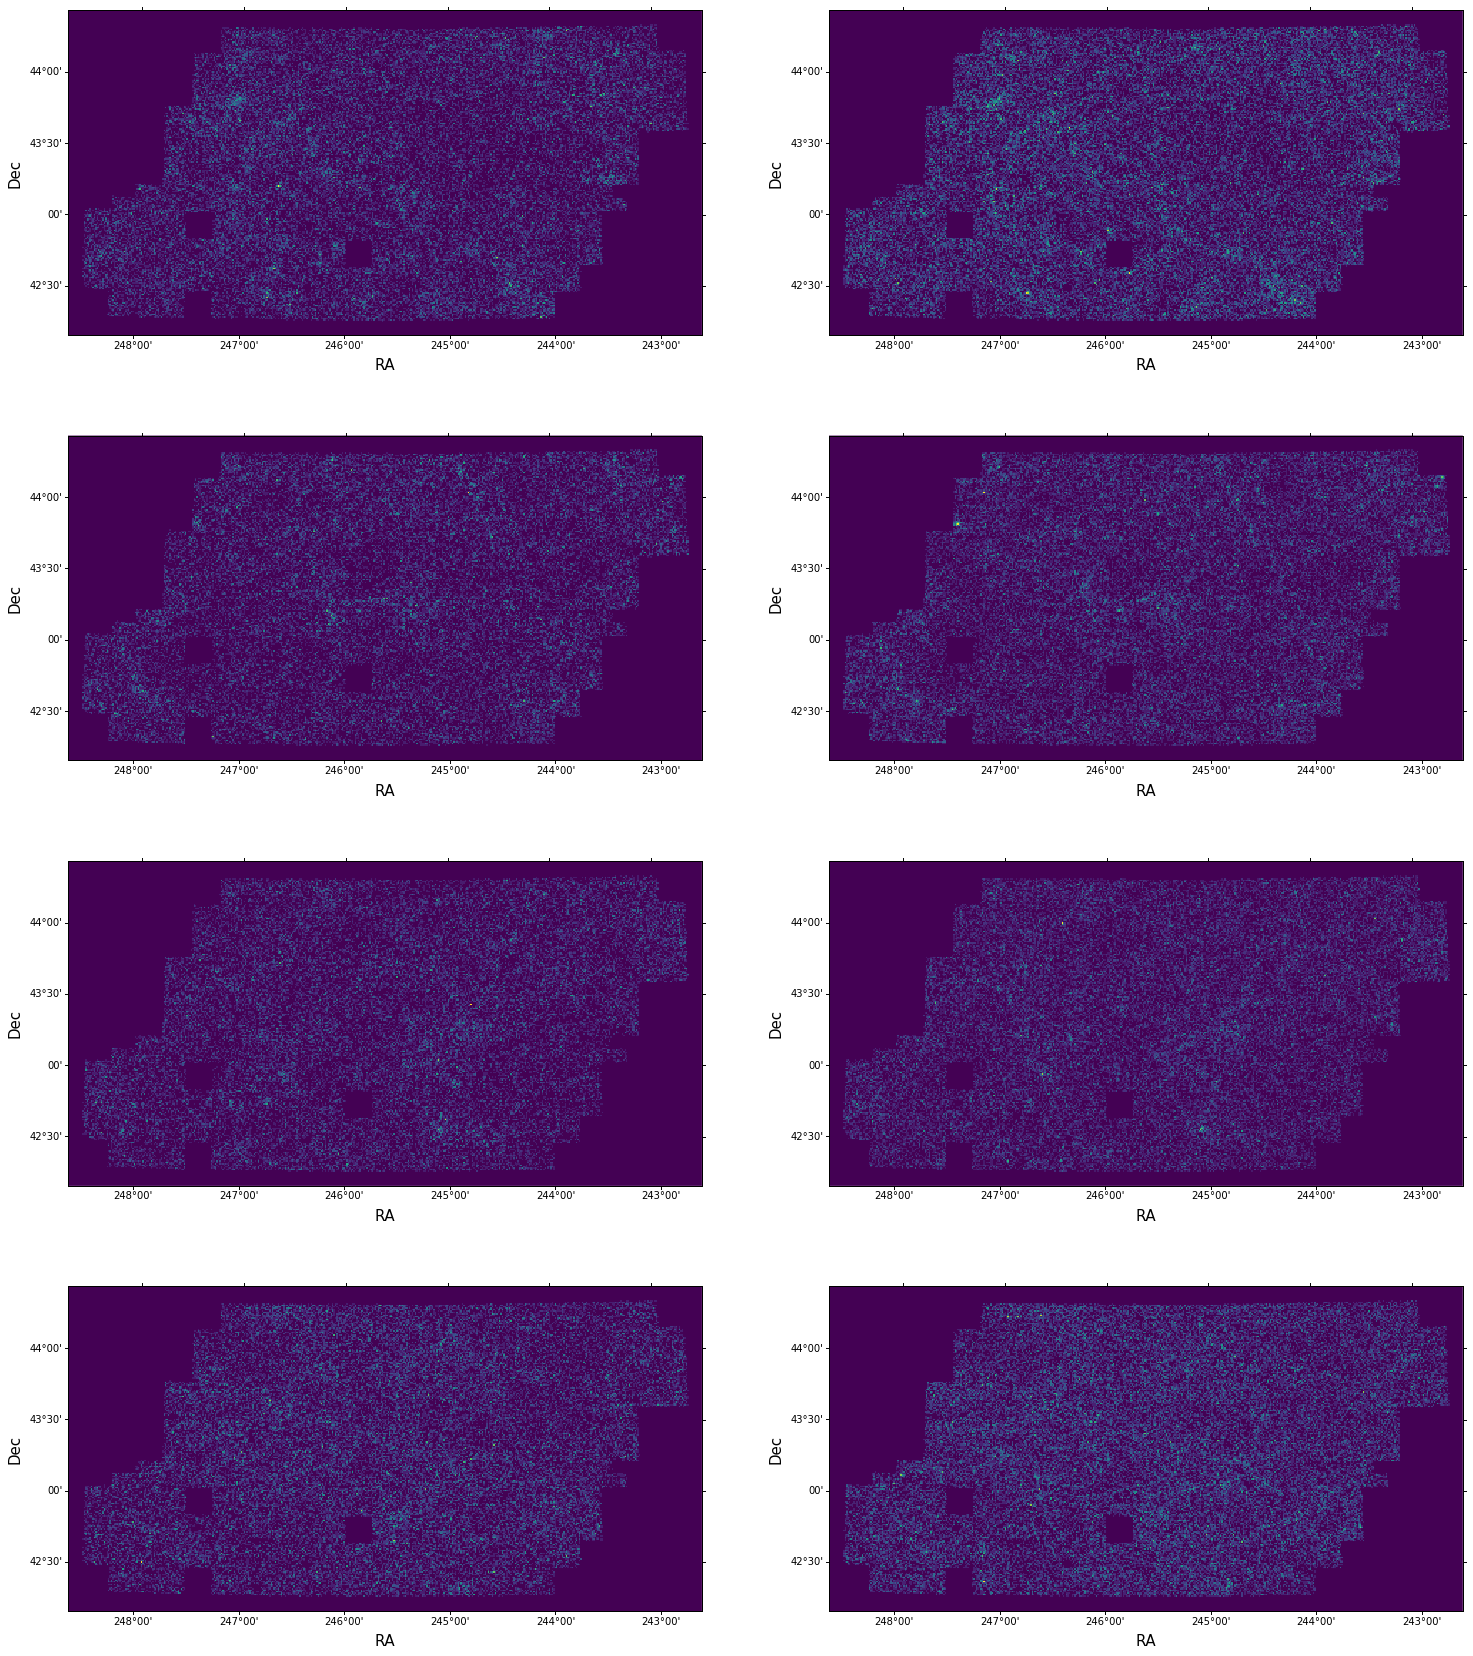

In [18]:
# JUST PLOTTING THINGS


# fsk.view_map(thismap[0])
# fig = plt.figure(figsize = (20,30))

# axes = [[fig.add_subplot(321, projection = fsk.wcs),fig.add_subplot(322)],
#         [fig.add_subplot(323, projection = fsk.wcs),fig.add_subplot(324)],
#         [fig.add_subplot(325, projection = fsk.wcs),fig.add_subplot(326)]]



fig, ax = plt.subplots(len(newmaps), 2, figsize = (25,30), subplot_kw = {'projection': fsk.wcs})
for binmap1, binmap2, (axis1, axis2) in zip(newmaps_split1, newmaps_split2, ax):
#     axis1.imshow(binmap, cmap = 'viridis')
    fsk.view_map(binmap1.ravel(), ax = axis1, addColorbar = False)
#     axis2.hist(binmap.ravel(), bins = 20, histtype = 'step', range = (0,20), log = True)
    fsk.view_map(binmap2.ravel(), ax = axis2, addColorbar = False)
savefig('./nmap_split.pdf', bbox_inches = 'tight')

0
-5


In [21]:
flatmap = fsk.pos2pix(subcat['ra'], subcat['dec'])
flatmap.shape

(139643,)

In [14]:
catalogs[0]

'/global/cscratch1/sd/damonge/HSC_ceci/WIDE_HECTOMAP_sirius_out'